### Dependencies

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None) #uncomment to see full dataframes
# pd.set_option('display.max_colwidth', None)
import glob
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re

### functions for log parsing

In [2]:
# helper functions for log parsing

def pass_no_pass(lines):
    for line in lines:
        if "PASSED" in line:
            return True
        elif "FAILED" in line:
            return False
    return

def parse_fp_for_int_diff(lines):
    vals = {'expected': [], 'actual': []}
    delimiters = [" ", "\n"]
    for i in range(len(lines)):
        if "INT" in lines[i]:
            for delimiter in delimiters:
                line = " ".join(lines[i+1].split(delimiter))
            split = list(map(int, line.split()))
            if ("Expected value of" in lines[i]) and ("in" not in lines[i]):
                # print(lines[i])
                vals['expected'].append(split)
            elif "Last value of" in lines[i]:
                # print(lines[i])
                vals['actual'].append(split)

    diffs = []
    for i in range(len(vals['actual'])):
        for j in range(len(vals['actual'][i])):
            diff = vals['expected'][i][j] - vals['actual'][i][j]
            if diff:
                diffs.append(diff)
    return diffs

def mask_errors(lines):
    errs = 0
    mask = False
    for line in lines:
        if "Error mask" in line:
            mask = True
            continue
        elif "SECTION" in line:
            if mask == True:
                return errs
        if mask:
            errs += sum([int(char) for char in line[:-1]])
    return errs

mmb_static_control = "/home/jacob/radTestLogBackup/mmb_static/log_staticMMBtest_run13log15_20240304_12-34-15.txt"
lines = open(mmb_static_control).readlines()
for i in range(len(lines)):
    if ("Last value of" in lines[i]) and ("INT" in lines[i]):
        for delimiter in [" ", "\n"]:
            line = " ".join(lines[i+1].split(delimiter))
        mmb_static_expected = list(map(int, line.split()))

def mmb_static_handle(lines):
    diffs = []
    for i in range(len(lines)):
        if ("Last value of" in lines[i]) and ("INT" in lines[i]):
            for delimiter in [" ", "\n"]:
                line = " ".join(lines[i+1].split(delimiter))
            line = line.split()
            for j in range(len(line)):
                diff = mmb_static_expected[j] - int(line[j])
                if diff:
                    diffs.append(diff)
    return diffs

In [3]:
#
# function to generate csv
# 

def generate_csv(keep=None):

    df = pd.DataFrame(columns=["kind", "run", "log", "lines", "time", "name", "path", "iters", "expected_vs_actual", "diff_count", "passed", "mask_errors"])

    for filename in glob.iglob('**', recursive=True):
        if keep:
            if keep not in filename:
                continue

        # skip exceptions, keep .txts with logs
        if ("log" not in filename) or (filename[-4:] != ".txt") or ("exception" in filename):
            continue
        tmp = filename.split('/')
        if not len(tmp) - 1:
            continue
        fp = open(filename, 'r')
        lines = fp.readlines()
        fp.close()

        kind, name = tmp[0], tmp[-1]

        # TODO: something with GXL logs
        if kind == "gxld":
            continue

        # get iteration count
        iter = [line for line in lines if "Exited" in line][0].split()[-1]
        # get count of i/o matches
        # if kind == "mmb_static":
            # int_diff = mmb_static_handle(lines)
        # else:
        int_diff = parse_fp_for_int_diff(lines)
        # get pass/fail
        passed = pass_no_pass(lines)

        # mask errors
        msk_errs = mask_errors(lines)


        # parse datetime from file name
        try:
            time = datetime.datetime.strptime(filename[-21:-4], '%Y%m%d_%H-%M-%S') # everything but GXLD logs
        except Exception:
            try:
                time = datetime.datetime.strptime(filename[-18:-4], '%m-%d-%y_%H-%M') # specifically for GXLD logs
            except Exception as e:
                raise(e)
        
        # get 'run' and 'log' numbers
        runlog = name.split('_')[2]
        run, log = [int(x) for x in runlog.split('run')[-1].split('log')]

        row = {"kind": kind, "run":run, "log": log, "lines": len(lines), "iters": int(iter), "time": time, "name": name,\
            "path": filename, "expected_vs_actual": int_diff, "diff_count": len(int_diff), "passed": passed, "mask_errors": msk_errs}
        if df.name.str.contains(name).any():
            continue
        else:
            df.loc[len(df), :] = row
    df = df.sort_values(by=['kind', 'run', 'log']).reset_index(drop=True)
    df = df.astype({"time": "datetime64[ns]"})
    df = df.sort_values(by='time')
    df.to_csv("./results.csv", index=False)

In [11]:
# create csv of testing logs
# change bool to generate csv if not created
gen_csv = False
if gen_csv:
    generate_csv("mmb_static")

logs = pd.read_csv("./results.csv")
# datetime handling and timezone fix
logs = logs.astype({"time": "datetime64[ns]"})
logs.time = logs.time - datetime.timedelta(hours=6)
logs.log[1], logs.run[1] = 0, 0 #handle duplicate run 2... TBD

# read tamu from excel
tamu = pd.read_excel("./GSI_TAMU_202311_scrubbed.xlsx", skiprows=1)
tamu.columns = tamu.columns.str.replace(' ', '_').str.lower()
tamu = tamu.drop(len(tamu) - 1) #drop last row of NaNs

/tmp/ipykernel_39475/2662794799.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs.log[1], logs.run[1] = 0, 0 #handle duplicate run 2... TBD
/tmp/ipykernel_39475/2662794799.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs.log[1], logs.run[1] = 0, 0 #handle duplicate run 2... TBD


### dev-diag log parsing

In [20]:
# dev diag logs 
# NON-APC testing

for filename in glob.iglob('./TAMU_dev_diagnostic_FailureLogs/**', recursive=True):
    if "gxld_log" not in filename:
        continue
    print(filename)
    lines = open(filename).read().split('\n')

    tests = []
    for i in range(len(lines)):
        if "test:" in lines[i]:
            tests.append(lines[i])

    for i in range(len(lines)):
        for test in tests:
            if test in lines[i]:
                print(test)
                if test == "sb 2k test:":
                    for sb_line in range(23):
                        tmp = [x.strip() for x in re.split('\t|\|', lines[i+2+sb_line]) if len(x)][1:]
                        for j in range(len(tmp)):
                            if tmp[j] != '0000':
                                tmp[j] = 'x'
                            else:
                                tmp[j] = ' '
                        print(tmp)
                else:
                    tmp = [x.strip() for x in re.split('\t|\|', lines[i+2]) if len(x)]
                    for j in range(len(tmp)):
                        if tmp[j] != '0000':
                            tmp[j] = 'x'
                        else:
                            tmp[j] = ' '
                    print(tmp)

./TAMU_dev_diagnostic_FailureLogs/gxld_log7_N
rsp16 test:
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
rsp16 with wa test:
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
rsp256 test:
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
rsp256 with wa test:
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
rsp2k test:
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
rsp2k with wa test:
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
rl 2k test:
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
sb 2k test:
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
[' ', ' ', ' ', ' ', '

In [21]:
# dev diag, APC tests

all_column_groups = []
for filename in glob.iglob('./TAMU_dev_diagnostic_FailureLogs/**', recursive=True):
    if "gxld_log" not in filename:
        continue
    lines = open(filename).read().split("\n")
    keep_after = "diego@demo1:~/Oct31_Tests/gxld$ dev_diagnostic"
    for i in range(len(lines)):
        if lines[i] == keep_after:
            lines = lines[i:]
            break
    column_groups = pd.Series([])
    for i in range(len(lines)):
        if "column group #" in lines[i]:
            if "APC A" in lines[i-1]:
                name = f"{lines[i-2]} {lines[i-1]}"
            else:
                name = f"{lines[i-6]} {lines[i-1]}"
            name = name.replace('\t', '')
            dev = lines[i+1]
            column_groups[name] = dev.replace('\t', '')
    column_groups = column_groups.apply(lambda dev: dev.split('|'))
    column_groups = column_groups.apply(lambda dev: [cell for cell in dev if len(cell)])
    all_column_groups.append(column_groups)

# create dataframe
diag = pd.DataFrame(columns=all_column_groups[0].index.to_list())
for col_grp in all_column_groups:
    diag.loc[len(diag), :] = col_grp

In [23]:
def error_pos(row):
    keep = []
    for i in range(len(row)):
        keep.append([])
        for j in range(len(row[i])):
            if 'x' in row[i][j]:
                keep[i].append(j)
    return keep
tmp = diag.apply(error_pos, axis=0)
tmp

In [25]:
# get error count per position over all logs
diag_pos = pd.DataFrame(columns = diag.columns.to_list())
for col in diag.columns.to_list():
    x = []
    for row in tmp[col]:
        for val in row:
            x.append(val)
    diag_pos.loc[0, col] = x
diag_pos.apply(lambda x: pd.Series(x[0]).value_counts()).fillna(0)

,dma l4 l2 direct test APC A:,dma l4 l2 direct test APC B:,dma l4 l2 indirect test APC A:,dma l4 l2 indirect test APC B:,dma l4 l2 mmb direct test APC A:,dma l4 l2 mmb direct test APC B:,dma l4 l2 mmb indirect test APC A:,dma l4 l2 mmb indirect test APC B:
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
7,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
9,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


### MMB investigation

In [26]:
actual_mmb = []
for path in logs.path:
    lines = open(path).read().split("\n")
    actual = [lines[i+1] for i in range(len(lines)) if "[INT] Last value of" in lines[i]]
    actual_mmb.append(list(map(int, actual[0].split())))
diffs = []
for i in range(len(actual_mmb)):
    diffs.append([])
    for j in range(0, len(actual_mmb)):
        diff = [bool(a - b) for a,b in zip(actual_mmb[i], actual_mmb[j])]
        diffs[i].append(sum(diff))
diffs_df = pd.DataFrame(diffs, columns=logs[["run", "log"]].apply(tuple, axis=1), index=logs[["run", "log"]].apply(tuple, axis=1))

In [27]:
def somename(row): #utter nonsense
    # print(row.name)
    for col in diffs_df.columns:
        if col[0] != row.name[0]:
            # (col[0], row.index[0])
            row[col] = None
        else:
            if abs(col[1] - row.name[1]) != 1:
                row[col] = ''
        if col[1] == row.name[1]:
            row[col] = ''
    return row
new_df = diffs_df.apply(somename, axis=1)
new_df.fillna('')

,"(1, 1)","(0, 0)","(4, 4)","(4, 5)","(4, 6)","(7, 7)","(7, 8)","(9, 9)","(2, 2)","(2, 3)","(2, 4)"
"(1, 1)",,,,,,,,,,,
"(0, 0)",,,,,,,,,,,
"(4, 4)",,,,141.0,,,,,,,
"(4, 5)",,,141.0,,0.0,,,,,,
"(4, 6)",,,,0.0,,,,,,,
"(7, 7)",,,,,,,0.0,,,,
"(7, 8)",,,,,,0.0,,,,,
"(9, 9)",,,,,,,,,,,
"(2, 2)",,,,,,,,,,172.0,
"(2, 3)",,,,,,,,,172.0,,0.0


### timestamp matching with graphs

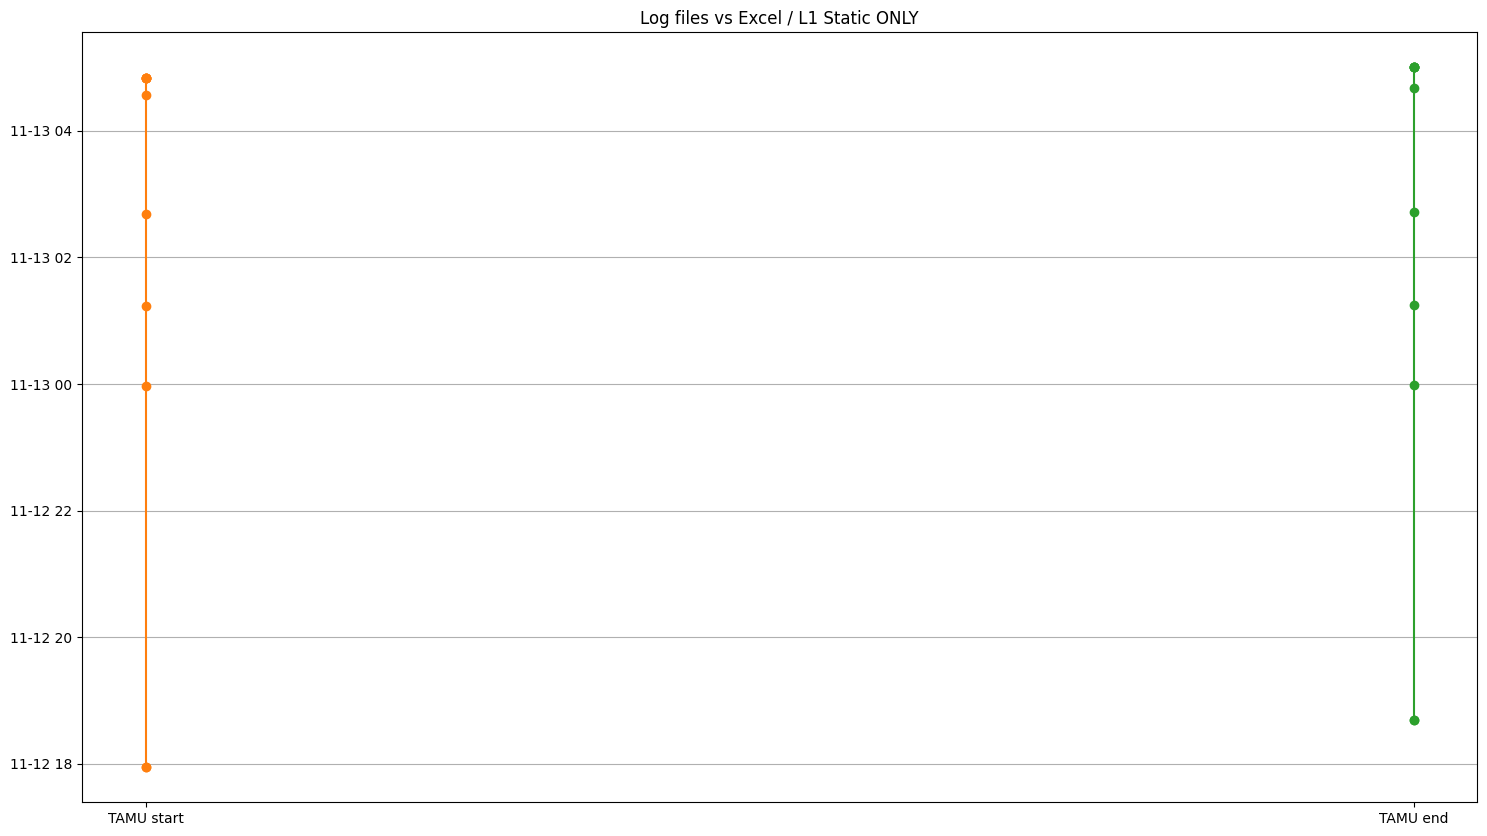

In [29]:
x = logs[logs.kind == 'l1_static'].reset_index(drop=True)
y = tamu[tamu.test_mode == "L1 Static"].reset_index(drop=True)
fig, ax = plt.subplots(figsize=(18,10))
ax.plot(['LOGS']*x.shape[0], x['time'], marker='o')
ax.plot(["TAMU start"]*y.shape[0], y["run_start_date_and_time"], marker='o')
ax.plot(["TAMU end"]*y.shape[0], y['run_stop'], marker='o')
ax.set_title("Log files vs Excel / L1 Static ONLY")
plt.grid(axis='y')
plt.show()